In [36]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

In [37]:
path = untar_data(URLs.BIWI_HEAD_POSE)

path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [38]:
Path.BASE_PATH = path # 상위경로는 다 지우는 듯?

In [39]:
# obj 파일은 쓰지 않고 biwi_head_pose 중 폴더에 접근하여 jpg, txt에 접근한다.
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [40]:
# get_image_files를 통해 재귀로 이미지파일을 쉽게 가져올 수 있다.
# 재귀 : 어떠한 것을 정의할 때 자기자신을 참조하는 것을 의미한다.

# 이미지 파일 명에 해당되는 포즈 파일명을 반환하는 함수 만들기

img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0]) # regex로 잘라야하나?

Path('23/frame_00448_pose.txt')

In [41]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

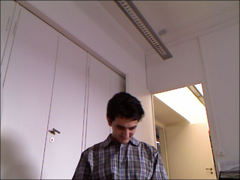

In [42]:
im.to_thumb(240)

In [43]:
# 머리의 중심 위치를 추출하는 함수

cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f), skip_header=3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1, c2])

In [44]:
get_ctr(img_files[0])

tensor([350.9904, 331.5477])

In [45]:
# 데이터 블록 만들기

biwi = DataBlock(
    blocks = (ImageBlock, PointBlock), # 독립은 이미지, 종속은 좌표를 반환 두 개다 같은 증강법을 사용한다.
    get_items = get_image_files, # 이미지 파일로부터 아이템을 가져온다
    get_y = get_ctr, # 좌표를 반환하는 함수를 넣었다. 좌표는 종속변수가 된다(레이블)
    splitter = FuncSplitter(lambda o : o.parent.name == '13'),
    batch_tfms=[*aug_transforms(size = (240,320)),   # *fun은 *args를 의미한다. 증강을 통해 데이터 사이즈를 240,320으로
                Normalize.from_stats(*imagenet_stats)]
)

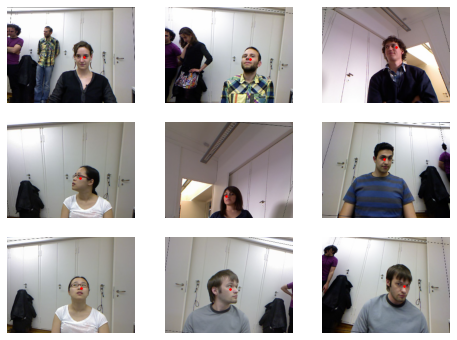

In [46]:
# 이미지와 레이블 데이터(좌표)가 정상인지 체크

dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [47]:
xb, yb = dls.one_batch()
xb.shape, yb.shape


yb[0] # TensorPoint([[-0.1319,  0.1534]])

# 한 배치에 64개의 이미지 데이터가 들어가고, 각 이미지 데이터는 3개 씩 서로 다른 사진을 가지고 있다. 하나의 사진은 크기가 240,320으로 조정되어서 다음과 같은 shape
# 종속변수의 좌표 레이블에서는 3개의 사진 값에 대한 평균 좌표값이 들어가지 않았나

TensorPoint([[0.0742, 0.2072]], device='cuda:0')

In [48]:
# 좌표의 범위가 -1,1 사이인 값을 예측하는 모델 학습 실시

learn = cnn_learner(dls, resnet18, y_range=(-1,1))

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


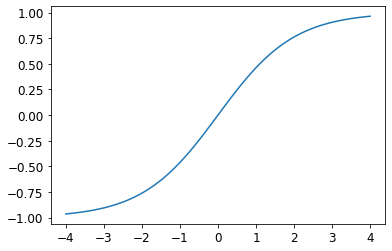

In [49]:
# y_range 에서는 자동으로 sigmoid_range 함수로 구현된다.

def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi - lo) + lo

# 모델 마지막 계층에 설정된다.

# 왜 모델의 출력 활성 범위를 (lo, hi)로 강제하는가

plot_function(partial(sigmoid_range, lo=-1, hi=1), min=-4, max=4)

In [50]:
dls.loss_func

# 평균제곱오차 sigma 1 ~ n =>(y^ - y)**2 

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.004365158267319202)

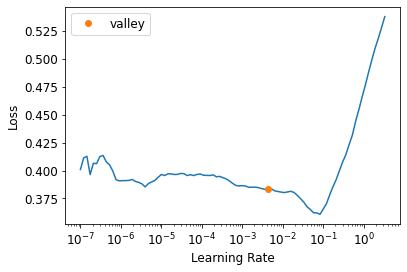

In [51]:
learn.lr_find()

In [52]:
lr = 1e-2
learn.fine_tune(3, lr)


# 1e-7 
# 0	0.416259	0.210857	02:14
# 1	0.408378	0.209931	02:13
# 2	0.414201	0.198103	02:12

epoch,train_loss,valid_loss,time
0,0.049124,0.012672,02:06


epoch,train_loss,valid_loss,time
0,0.008322,0.002083,02:14
1,0.003043,0.000534,02:14
2,0.001447,0.000390,02:13


In [53]:
math.sqrt(0.0001)

# 0.0001 손실에서 제곱근을 하면 평균 좌표 예측 오차가 나온다

0.01

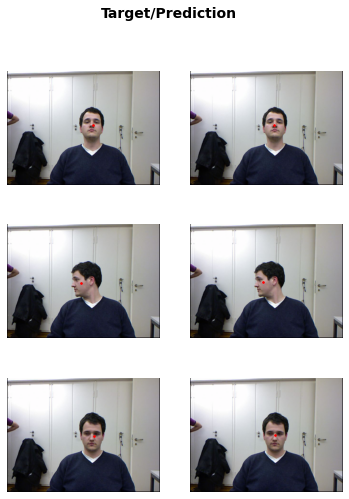

In [55]:
# 학습 결과

learn.show_results(ds_idx = 1, max_n = 3, figsize=(6,8))